# Experiment 7 - Analysis

In [1]:
from copy import deepcopy
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import mannwhitneyu, shapiro

from population.population import Population
from utils.dictionary import *
from utils.myutils import load_dict

In [2]:
# Hyperparameters
use_backup = True
populations = ['default', 'biased', 'gru_nr']
max_v = 50

In [3]:
# Parameters
FOLDER = f"population{'_backup' if use_backup else ''}/storage/experiment7/"
COLORS = [sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2]]

## Load in the data

### Number of generations until solution

In [4]:
df_gens = pd.DataFrame()
for p in populations:
    gens = []
    for v in range(1, max_v+1):
        gens.append(len(glob(f'{FOLDER}{p}/v{v}/generations/gen_*')))
    df_gens[p] = gens

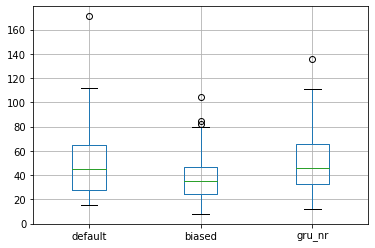

In [5]:
df_gens.boxplot()

### Found solution

In [6]:
%%capture
df_solutions = pd.DataFrame()
for p in populations:
    solutions = []
    for v in range(1, max_v+1):
        pop = Population(
                name=f'{p}/v{v}',
                folder_name='experiment7',
                use_backup=use_backup,
        )
        solutions.append(deepcopy(pop.best_genome))
    df_solutions[p] = solutions

In [7]:
def get_genome_params(g, pop_name):
    # Recurrent unit
    result = [b for b in g.nodes[2].bias_h]
    result += [w[0] for w in g.nodes[2].weight_xh]
    result += [w[0] for w in g.nodes[2].weight_hh]
    
    # Other parameters
    result += [g.connections[(-1, 1)].weight]
    if 'biased' not in pop_name: result += [g.connections[(-1, 2)].weight]
    result += [g.connections[(2, 1)].weight, g.nodes[1].bias]
    return result

In [8]:
def get_head(pop_name):
    head = []
    if 'gru_nr' in pop_name:
        head += ['bias_z', 'bias_h']
        head += ['weight_xz', 'weight_xh']
        head += ['weight_hz', 'weight_hh']
    else:
        head += ['bias_r', 'bias_z', 'bias_h']
        head += ['weight_xr', 'weight_xz', 'weight_xh']
        head += ['weight_hr', 'weight_hz', 'weight_hh']
        
    head += ['c0']
    if 'biased' not in pop_name: head += ['c1']
    head += ['c2', 'bias_rw']
    return head

In [9]:
def create_overview(pop_name):
    data = []
    for solution in df_solutions[pop_name].values:
        data.append(get_genome_params(solution, pop_name))
    df_default = pd.DataFrame(data, columns=get_head(pop_name))
    
    plt.figure(figsize=(20, 5))
    df_default.boxplot()
    plt.ylim(-6,6)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(15,5))
    for i, col in enumerate(df_default.columns):
        plt.subplot(int(len(df_default.columns)/5+1),5,i+1)
        sns.violinplot(df_default[col])
        plt.title(col)
        if 'bias' in col:
            plt.xlim(-3,3)
        else:
            plt.xlim(-6,6)
        plt.yticks([])
    plt.tight_layout()
    plt.show()
    plt.close()

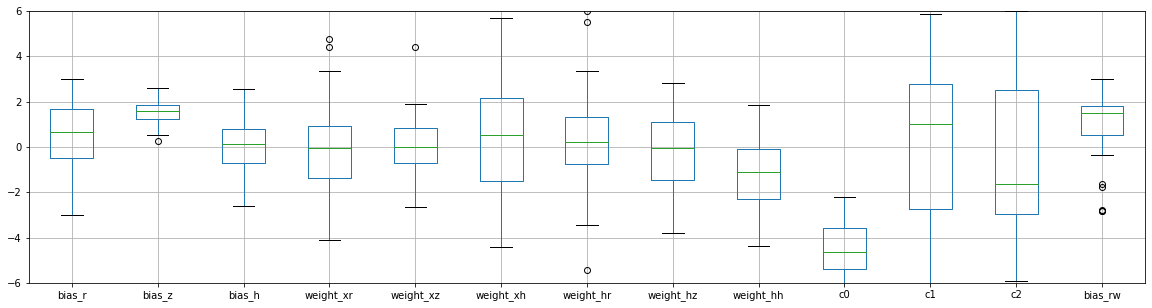

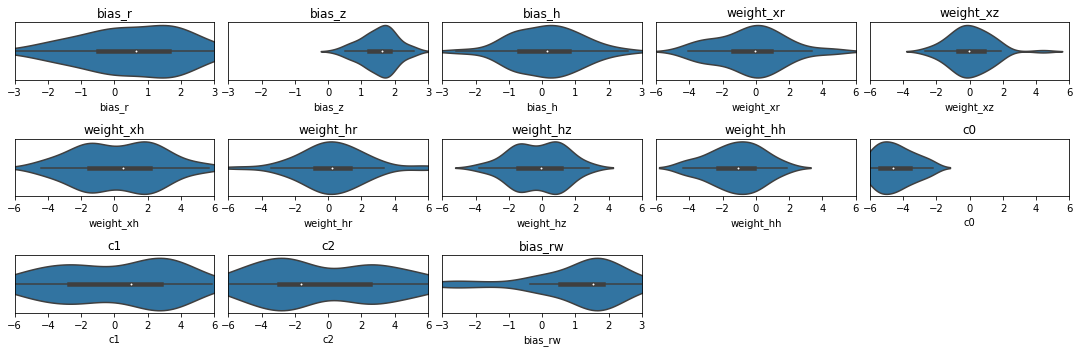

In [10]:
create_overview('default')

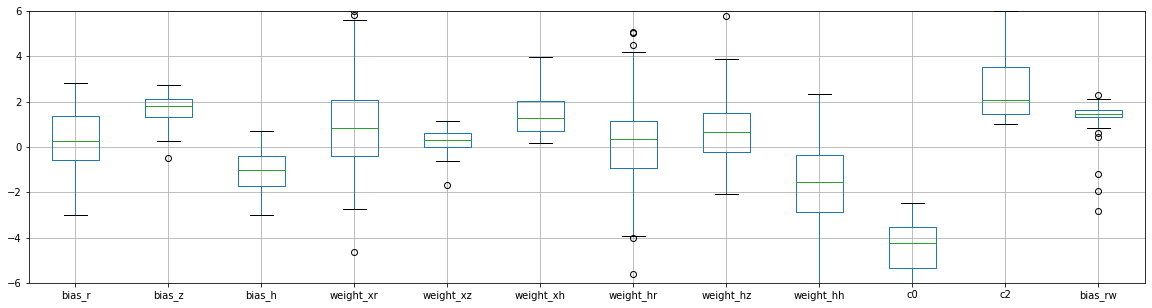

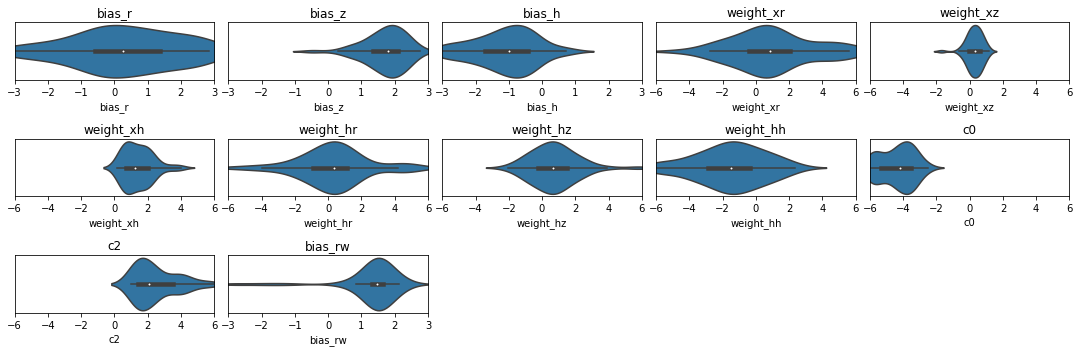

In [11]:
create_overview('biased')

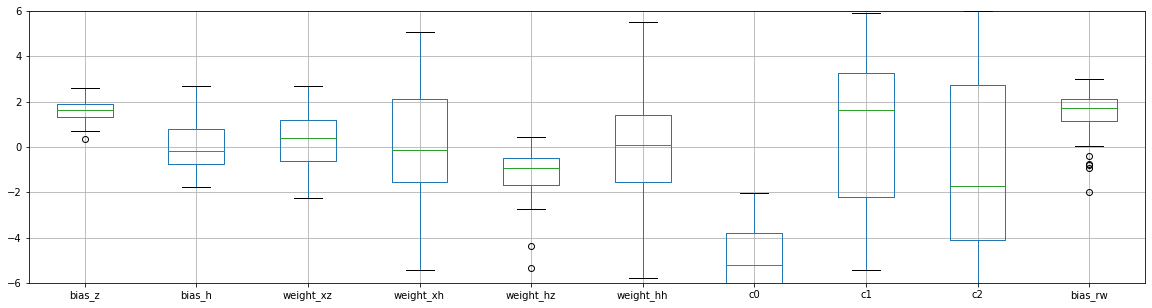

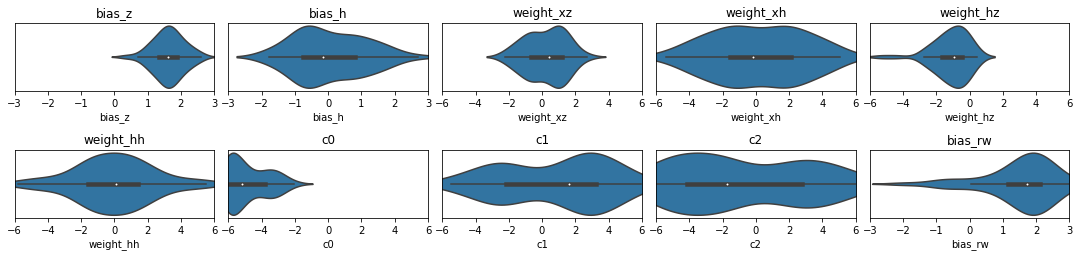

In [12]:
create_overview('gru_nr')

## Merge evaluation scores

NOTE: This part of the script assumes that `bash evaluation.bash` has run on each of the populations for every requested version.

### Collect the data

In [13]:
# 'default' population
data = []
for v in range(1, max_v+1):
    max_g = len(glob(f"{FOLDER}default/v{v}/evaluation/0*"))  # Assumption: no 10000 generations needed
    row = []
    for g in range(max_g):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}default/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FINISHED]/100 for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_default = pd.DataFrame(data).transpose()  # Rows indicate generations
df_default.columns = [v for v in range(1, max_v+1)]
df_default = df_default.fillna(1)  # nan values are those versions that already finished
df_default.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.0556,0.0556,0.0000,0.0556,0.0000,0.0000,0.0000,0.0000,0.1111,0.0000,...,0.0556,0.0000,0.1111,0.0556,0.0000,0.0000,0.0000,0.1111,0.0556,0.0556
1,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,...,0.0556,0.3889,0.2222,0.2222,0.2222,0.1667,0.2222,0.2222,0.2222,0.2222
2,0.2222,0.2222,0.2778,0.2222,0.1111,0.2222,0.2222,0.2778,0.2222,0.2222,...,0.2222,0.3889,0.1667,0.2222,0.2222,0.1667,0.2222,0.2222,0.4444,0.2222
3,0.2222,0.2222,0.3333,0.2222,0.2222,0.3333,0.2778,0.2778,0.2222,0.2222,...,0.2222,0.5000,0.1111,0.2222,0.2222,0.2222,0.2222,0.2222,0.5556,0.3333
4,0.1667,0.3333,0.3333,0.2222,0.2222,0.3333,0.2778,0.1667,0.2222,0.2222,...,0.2222,0.6111,0.1667,0.2222,0.2222,0.2222,0.2222,0.2222,0.5556,0.6667


In [14]:
# 'biased' population
data = []
for v in range(1, max_v+1):
    max_g = len(glob(f"{FOLDER}biased/v{v}/evaluation/0*"))  # Assumption: no 10000 generations needed
    row = []
    for g in range(max_g):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}biased/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FINISHED]/100 for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_biased = pd.DataFrame(data).transpose()  # Rows indicate generations
df_biased.columns = [v for v in range(1, max_v+1)]
df_biased = df_biased.fillna(1)  # nan values are those versions that already finished
df_biased.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.1111,0.0000,0.0556,0.0556,0.0556,0.0000,0.0556,0.0000,0.1667,0.0000,...,0.1667,0.1667,0.0556,0.0556,0.0000,0.0556,0.0000,0.1111,0.1667,0.0000
1,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,...,0.2222,0.2778,0.2222,0.2222,0.2222,0.2222,0.2222,0.2778,0.2222,0.2222
2,0.2222,0.2222,0.2222,0.2222,0.3333,0.5000,0.1667,0.2222,0.2222,0.2222,...,0.2222,0.2778,0.2222,0.2222,0.2222,0.1667,0.1667,0.3889,0.2222,0.3889
3,0.2778,0.2222,0.2778,0.2222,0.3333,0.5000,0.1667,0.2778,0.3333,0.2222,...,0.2222,0.2778,0.2222,0.2222,0.2778,0.1667,0.2222,0.8889,0.2222,0.3889
4,0.2778,0.2778,0.3333,0.2222,0.3333,0.5000,0.2222,0.2222,0.3333,0.1667,...,0.2222,0.1667,0.2222,0.2222,0.2778,0.3333,0.3889,0.9444,0.2222,0.3889


In [15]:
# 'gru_nr' population
data = []
for v in range(1, max_v+1):
    max_g = len(glob(f"{FOLDER}gru_nr/v{v}/evaluation/0*"))  # Assumption: no 10000 generations needed
    row = []
    for g in range(max_g):
        # Read in the generation's results
        results = load_dict(f"{FOLDER}gru_nr/v{v}/evaluation/{g:05d}/results")

        # Use the best performing genome
        row.append(max([results[k][D_FINISHED]/100 for k in results.keys()]))
    data.append(row)

# Create a dataframe containing the data
df_gru_nr = pd.DataFrame(data).transpose()  # Rows indicate generations
df_gru_nr.columns = [v for v in range(1, max_v+1)]
df_gru_nr = df_gru_nr.fillna(1)  # nan values are those versions that already finished
df_gru_nr.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.0000,0.1111,0.0556,0.0556,0.0556,0.0556,0.0556,0.1111,0.0000,0.0000,...,0.1667,0.0556,0.0000,0.0000,0.0556,0.0000,0.0000,0.1111,0.0000,0.0000
1,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,...,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.2222,0.1667,0.2222,0.3333
2,0.2222,0.2222,0.2222,0.1111,0.2222,0.2222,0.2778,0.2222,0.3333,0.2222,...,0.2222,0.2778,0.3333,0.2222,0.2222,0.2222,0.3889,0.2222,0.2778,0.3333
3,0.2222,0.1667,0.2222,0.2222,0.2222,0.2222,0.2778,0.1667,0.2222,0.2222,...,0.2222,0.2778,0.3333,0.2778,0.1667,0.2778,0.3889,0.2778,0.2222,0.3333
4,0.2222,0.2222,0.2222,0.2222,0.2222,0.1667,0.2778,0.1667,0.3333,0.2222,...,0.1667,0.3333,0.2778,0.2222,0.2222,0.2778,0.3889,0.2222,0.2778,0.3889


### Visualize

Graph is similar to other experiments (work only in interquartile range), but now with finished ratio on y-axis and number of generations on x-axis.

In [16]:
plot_default = True
plot_biased = True
plot_gru_nr = True

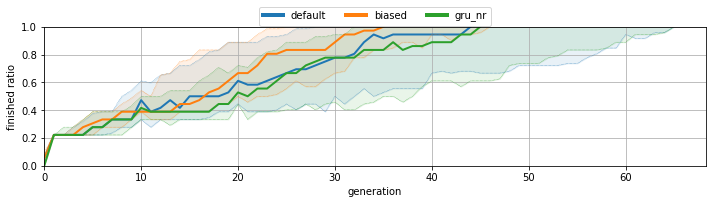

In [17]:
plt.figure(figsize=(10, 3))


### DEFAULT ###
if plot_default:
    c = 0
    # Get quantiles
    q1 = df_default.quantile(0.25, axis=1).values
    q2 = df_default.quantile(0.50, axis=1).values
    q3 = df_default.quantile(0.75, axis=1).values

    # Modify the lists
    q13_stop = np.where(q1 == 1)[0][0]
    q1 = q1[:q13_stop+1]
    q3 = q3[:q13_stop+1]
    q2_stop = np.where(q2 == 1)[0][0]
    q2 = q2[:q2_stop+1]

    # Plot
    plt.plot([i for i in range(len(q1))], 
             q1, 
             color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q3))], 
             q3, color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q2))], 
             q2, 
             color=COLORS[c], 
             linestyle="-", 
             linewidth=2, 
             label='default')
    plt.fill_between([i for i in range(len(q1))],
                     q1, 
                     q3,
                     color=COLORS[c], 
                     alpha=0.1)


### BIASED ###
if plot_biased:
    c = 1
    # Get quantiles
    q1 = df_biased.quantile(0.25, axis=1).values
    q2 = df_biased.quantile(0.50, axis=1).values
    q3 = df_biased.quantile(0.75, axis=1).values

    # Modify the lists
    q13_stop = np.where(q1 == 1)[0][0]
    q1 = q1[:q13_stop+1]
    q3 = q3[:q13_stop+1]
    q2_stop = np.where(q2 == 1)[0][0]
    q2 = q2[:q2_stop+1]

    # Plot
    plt.plot([i for i in range(len(q1))], 
             q1, 
             color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q3))], 
             q3, color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q2))], 
             q2, 
             color=COLORS[c], 
             linestyle="-", 
             linewidth=2, 
             label='biased')
    plt.fill_between([i for i in range(len(q1))],
                     q1, 
                     q3,
                     color=COLORS[c], 
                     alpha=0.1)


### GRU-NR ###
if plot_gru_nr:
    c = 2
    # Get quantiles
    q1 = df_gru_nr.quantile(0.25, axis=1).values
    q2 = df_gru_nr.quantile(0.50, axis=1).values
    q3 = df_gru_nr.quantile(0.75, axis=1).values

    # Modify the lists
    q13_stop = np.where(q1 == 1)[0][0]
    q1 = q1[:q13_stop+1]
    q3 = q3[:q13_stop+1]
    q2_stop = np.where(q2 == 1)[0][0]
    q2 = q2[:q2_stop+1]

    # Plot
    plt.plot([i for i in range(len(q1))], 
             q1, 
             color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q3))], 
             q3, color=COLORS[c], 
             linestyle=":", 
             linewidth=.5)
    plt.plot([i for i in range(len(q2))], 
             q2, 
             color=COLORS[c], 
             linestyle="-", 
             linewidth=2, 
             label='gru_nr')
    plt.fill_between([i for i in range(len(q1))],
                     q1, 
                     q3,
                     color=COLORS[c], 
                     alpha=0.1)


# Show the figure
leg = plt.legend(loc='upper center',
                 bbox_to_anchor=(0.5, 1.18),
                 fancybox=True,
                 fontsize=10,
                 ncol=len(populations))
for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.xlabel("generation")
plt.xlim(0)
plt.ylabel('finished ratio')
plt.ylim(0, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(f"delete_me/experiment7.png", bbox_inches='tight', pad_inches=0.02)
# plt.savefig(f"delete_me/experiment7.eps", format="eps", bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

## Statistical analysis

In [18]:
df_gens.head()

,default,biased,gru_nr
0,23,33,36
1,171,85,44
2,77,31,48
3,40,42,45
4,22,47,53


In [19]:
Q1 = df_gens.quantile(0.25)
Q3 = df_gens.quantile(0.75)
IQR = Q3 - Q1
IQR

default    37.50
biased     22.25
gru_nr     32.75
dtype: float64

In [20]:
# Normaized dataframes (without any outliers)
df_n = df_gens[(df_gens >= (Q1 - 1.5 * IQR)) & (df_gens <= (Q3 + 1.5 * IQR))]

# Quantile dataframes (only values in the quantiles are kept)
# df_n = df[(df >= Q1) & (df <= Q3)]

df_n.head()

,default,biased,gru_nr
0,23.0,33.0,36.0
1,NaN,NaN,44.0
2,77.0,31.0,48.0
3,40.0,42.0,45.0
4,22.0,47.0,53.0


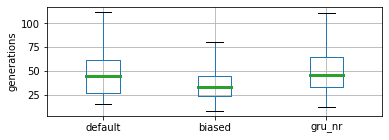

In [21]:
plt.figure(figsize=(6,2))
df_n.boxplot(whis=[0,100],  # Do not define outliers anymore
             medianprops={'linewidth':3})
plt.ylabel('generations')
#plt.savefig("temp_boxplot.png", bbox_inches='tight', pad_inches=0.02)
plt.savefig("delete_me/temp_boxplot.eps", format='eps', bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close()

In [22]:
# Example of the Shapiro-Wilk Normality Test
for pop in populations:
    stat, p = shapiro(df_n[pop].dropna())
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print(f'{pop} is probably Gaussian (p={p:.5f})')
    else:
        print(f'{pop} is probably not Gaussian (p={p:.5f})')

stat=0.938, p=0.012
default is probably not Gaussian (p=0.01196)
stat=0.968, p=0.213
biased is probably Gaussian (p=0.21282)
stat=0.914, p=0.002
gru_nr is probably not Gaussian (p=0.00165)


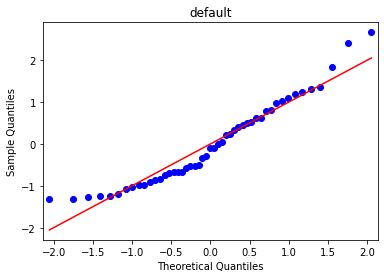

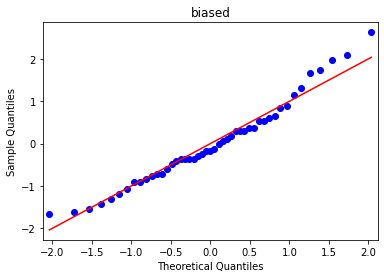

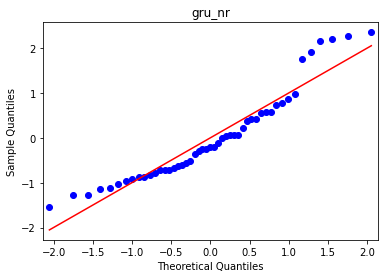

In [23]:
for p in populations:
    sm.qqplot(df_n[p].dropna(), line ='s', fit=True) 
    plt.title(p)
    plt.show() 

In [24]:
for i in range(len(populations)):
    pop1 = populations[i]
    for j in range(i+1, len(populations)):
        pop2 = populations[j]
        stat, p = mannwhitneyu(df_n[pop1].dropna(), 
                               df_n[pop2].dropna(), 
                               use_continuity=False, 
                               alternative='two-sided')
        print(f'{pop1} vs {pop2} -  p={p} - {"significant" if p < .05 else "insignificant"}')

default vs biased -  p=0.04117989051221338 - significant
default vs gru_nr -  p=0.453379185697781 - insignificant
biased vs gru_nr -  p=0.00295023478048865 - significant
